<a href="https://colab.research.google.com/github/naqi7272/Finetune_TTS_Model/blob/master/lstm_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install lmfit

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from pandas import DataFrame as df
import fnmatch
import os
import csv
from lmfit import Model
import sympy as sym
import scipy.optimize as opt
from datetime import datetime
from IPython.display import Latex
from lmfit.models import LorentzianModel
from lmfit.models import GaussianModel
from lmfit import Model, Parameters, minimize, fit_report
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import norm,cauchy,lognorm
import array as arr
from scipy import stats as st
from matplotlib import cm


In [3]:

from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import PairwiseKernel
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn import preprocessing

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import Counter

from numpy.random import seed
from numpy.random import randn

In [4]:
#DEFINING WILLINGALE MODEL
def Willingale_if(t, F_a, alpha, T_a):
    if t<T_a:
        return F_a * np.exp(alpha - (t*alpha)/T_a)
    else:
        return F_a * np.power((t / T_a),(-alpha))

def Willingale(t, F_a, alpha, T_a):
    y = np.zeros(t.shape)
    for j in range(len(y)):
        y[j]=Willingale_if(t[j], F_a, alpha, T_a)
    return y

def log_Willingale_if(logt, logFa, alpha, logTa):
    if logt<logTa:
        return logFa + np.log10(np.e) * alpha * (1.0 - 10**logt/(10**logTa))
    else:
        return logFa - alpha * (logt - logTa)

def log_Willingale(logt, logFa, alpha, logTa):
    y = np.zeros(logt.shape)
    for j in range(len(y)):
        y[j]=log_Willingale_if(logt[j], logFa, alpha, logTa)
    return y

#DEFINING CAUCHY LORENTZIAN FUNCTION
def Cauchy_Lorentz(x, x_0, gamma):
    return ( 1 / (np.pi * gamma * (1 + ( (x-x_0) / gamma )**2 )))


GRB130609B


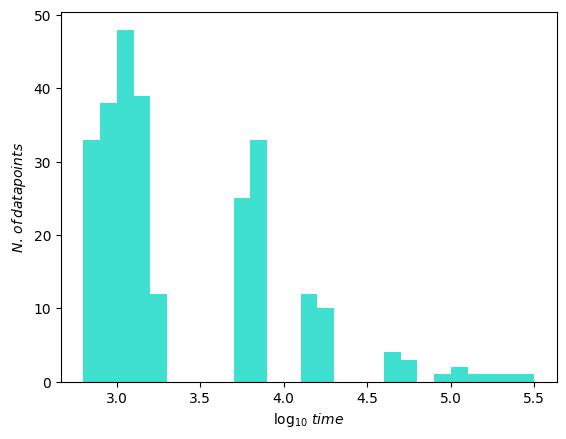

<Figure size 640x480 with 0 Axes>

In [5]:
header_names=['t', 'pos_t_err', 'neg_t_err', 'flux', 'pos_flux_err', 'neg_flux_err']

GRB_parameters = pd.read_csv("545_GRBs_parameters.csv", header=0, index_col=0)

#GRB_new = pd.read_csv("/content/drive/MyDrive/Astro/LC Reconstruction 2/GRB_segregated_new.csv", header=0)

GRBIDs_arr = GRB_parameters.index[:] #GRB_new.iloc[:,0]

#ARRAY TO STORE GRB NAMES
Names=[]

GRB_Name="GRB130609B"


#print(GRBIDs_arr.head())
#for i in range(528,len(GRBIDs_arr)):

    #ARRAYS TO STORE VALUES OF ORIGINAL WILLINGALE PARAMETERS FOR ALL GRBs IN THE LOOP

print(GRB_Name)
#cleaned_data = pd.read_csv("C:/Users/biagi/Desktop/GRB-SFR/LCR/All_GRBs_reconstruction/LC Reconstruction 2/GRBs_cleaned/"+GRB_Name+"_cleaned.csv", verbose=False, skiprows=2, skip_blank_lines=True, sep=',', dtype=float, header=None, names=header_names, na_filter=True)
trimmed_data = pd.read_csv(GRB_Name+"_trimmed.csv", verbose=False, skiprows=1, skip_blank_lines=True, sep=',', dtype=float, header=None, names=header_names)
#CLEANED DATA CONTAINS FLUX VS TIME DATA OF PROMPT AS WELL AS AFTERGLOW REGION (COMPLETE LC.). PLEASE REFER TO THE DESCRIPTION AT THE BEGINNING.
#TRIMMED DATA CONTAINS FLUX VS TIME DATA OF AFTERGLOW REGION.

#DEFINING DENSITY FACTOR
density_factor = 1

#Here we obtain the fitting parameters.

#Ta is in log scale. Fa in log scale. Alpha is linear scale.
#And tt and tfinal in log scale.
log_T_a = GRB_parameters.loc[GRB_Name, "logTa_best"]
log_T_a_min = GRB_parameters.loc[GRB_Name, "logTa_min"]
log_T_a_max = GRB_parameters.loc[GRB_Name, "logTa_max"]

log_F_a = GRB_parameters.loc[GRB_Name, "logFa"]
log_F_a_min = GRB_parameters.loc[GRB_Name, "logFa_min"]
log_F_a_max = GRB_parameters.loc[GRB_Name, "logFa_max"]

alpha = GRB_parameters.loc[GRB_Name, "alpha_best"]
alpha_min = GRB_parameters.loc[GRB_Name, "alpha_min"]
alpha_max = GRB_parameters.loc[GRB_Name, "alpha_max"]

log_Tt = GRB_parameters.loc[GRB_Name, "logTt"]
#log_Tfinal = GRB_parameters.loc[GRB_Name, "logTfinal"]


#FETCHING MAXIMUM AND MINIMUM VALUE OF FLUXES AND TIME VALUES FROM TRIMMED DATA
#THESE VALUES ARE IN LINEAR SCALE
max_fluxes = np.max(trimmed_data["flux"])
min_fluxes = np.min(trimmed_data["flux"])

max_ts = np.max(trimmed_data["t"])
min_ts = np.min(trimmed_data["t"])


#ABOVE VALUES IN LOG SCALE
log_max_fluxes = np.log10(max_fluxes)
log_min_fluxes = np.log10(min_fluxes)

log_max_ts = np.log10(max_ts)
log_min_ts = np.log10(min_ts)

#DEFINING THE ERROR VALUES FROM DATA FILE IN LINEAR SCALE

#for time
positive_ts_err = trimmed_data["pos_t_err"]
negative_ts_err = trimmed_data["neg_t_err"]

#for flux
positive_fluxes_err = trimmed_data["pos_flux_err"]
negative_fluxes_err = trimmed_data["neg_flux_err"]


#READING TIME AND FLUXES FROM THE TRIMMED DATA
#THESE VALUES ARE IN LINEAR SCALE
ts, fluxes = trimmed_data["t"].to_numpy(), trimmed_data["flux"].to_numpy()

#ABOVE VALUES IN LOG SCALE
log_ts, log_fluxes = np.log10(ts), np.log10(fluxes)


# ERROR ON THE FLUXES
pos_fluxes= fluxes + positive_fluxes_err
neg_fluxes= fluxes + negative_fluxes_err


# GENERATES TIME VALUES AT EQUAL INTERVALS IN RANGE OF TS IN LINEAR SCALE
# THIS IS TO BE USED FOR GENERATING THE TIMES AT WHICH WE RECONSTRUCT THE LC
# IT IS EQUAL TO THE NUMBER OF DATA POINTS AS THE ORIGINAL LIGHT CURVE
recon_t = np.geomspace(np.min(ts), np.max(ts), density_factor*len(ts))

#ABOVE VALUE IN LOG SCALE
log_recon_t = np.log10(recon_t)
log_recon_t = log_recon_t.reshape(-1,1)

totdensity=len(log_ts)/(max(log_ts)-min(log_ts))
    # print(totdensity)

n, bins, patches = plt.hist(log_ts, bins=np.arange(min(log_ts), max(log_ts)+0.1, step=0.1), color='turquoise')
nmean=np.mean(n)
nstd=np.std(n)

edges=np.histogram_bin_edges(log_ts, bins='auto')
#print(edges)

# seed random number generator
#print(n)
#print(np.max(n)/2)
# plt.hist(log_ts, bins=np.arange(min(log_ts), max(log_ts)+0.1, step=0.1), color='turquoise')
plt.xlabel("$\log_{10}\,time$")
plt.ylabel("$N.\,of\,datapoints$")
plt.show()
plt.clf()

gapslist=[]

for ff in range(0,len(log_ts)-1):
    lowbound=log_ts[ff]
    upbound=log_ts[ff+1]

    if np.abs(upbound-lowbound)>=0.03: #np.min(totalgaps): #0.10:

        gapslist.append([lowbound,upbound,np.abs(upbound-lowbound)])

pivotkeep=[]
for ii in range(len(log_recon_t)):
    for jj in range(len(gapslist)):
        if gapslist[jj][0]<=log_recon_t[ii]<=gapslist[jj][1]:
            pivotkeep.append(ii)

#print(pivotkeep)

logtimekeep=[[log_recon_t[f][0]] for f in pivotkeep]

logtimekeeparray=np.array(logtimekeep)

#print(type(log_recon_t))
#print(type(logtimekeeparray))

log_recon_t = logtimekeeparray

#CALCULATING ERRORBAR IN LINEAR SCALE
ts_error = (positive_ts_err - negative_ts_err )/2
fluxes_error = (positive_fluxes_err - negative_fluxes_err)/2

#CALCULATING ERRORBAR IN LOG SCALE

pos_log_fluxes = np.log10(pos_fluxes)
neg_log_fluxes = np.log10(neg_fluxes)

#ERROR PARAMETERS (LOG)
log_F_a_err = (float(log_F_a_max) - float(log_F_a_min))/2
log_T_a_err= (float(log_T_a_max) - float(log_T_a_min))/2
alpha_err = (float(alpha_max) - float(alpha_min))/2

#CALLING LOG WILLINGALE FUNCTION ON LOG PARAMETER
log_Willingale_line = log_Willingale(log_recon_t, log_F_a, alpha, log_T_a)

#RESIDUALS IN LOG SCALE
log_Willingale_line = log_Willingale(log_ts, log_F_a, alpha, log_T_a)
#log_Willingale_min = log_Willingale(log_ts, log_F_a_min, alpha_min, log_T_a_min)  #THESE COMMENTED LINES CALCULATE THE MINIMUM AND MAXIMUM WILLINGALE FIT.
#log_Willingale_max = log_Willingale(log_ts, log_F_a_max, alpha_max, log_T_a_max)

log_residuals = log_fluxes-log_Willingale_line

#FITTING THE LOG RESIDUAL HISTOGRAM WITH GAUSSIAN DISTRIBUTION

parameters = st.norm.fit(log_residuals, floc=0)
#print("The parameters of the fit are: "+ str(parameters))
fitted_dist = st.norm(scale=parameters[1])

st.kstest(log_residuals, fitted_dist.cdf)

log_Willingale_line = log_Willingale(log_recon_t, log_F_a, alpha, log_T_a)


In [6]:

# Symmetric Log Scale Transformation
def symmetric_log_scale(flux_values, a):
    return np.log(np.abs(flux_values / a)) * np.sign(flux_values)

a = fluxes.min()  #minimum value of flux

#prepare data
symlog_flux = symmetric_log_scale(fluxes, a)
log_ts = np.log10(ts)

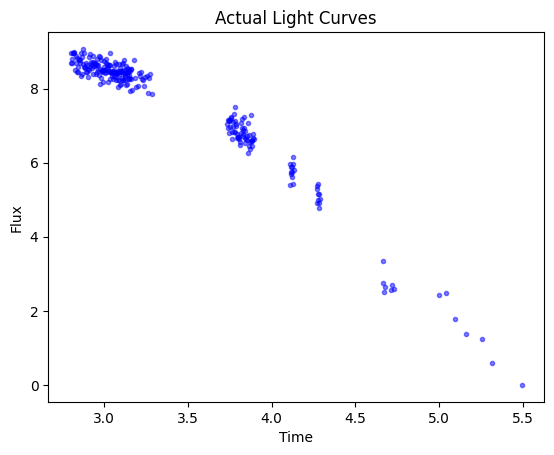

In [7]:
plt.plot(log_ts,symlog_flux, 'b.', alpha=0.5)


plt.xlabel('Time')
plt.ylabel('Flux')
plt.title(f'Actual Light Curves')
plt.show()

In [8]:
upsampled_times = []
upsampled_fluxes = []

for i in range(len(log_ts) - 1):
    start_time = log_ts[i]
    end_time = log_ts[i + 1]
    gap = end_time - start_time

    # Check if the gap exceeds the threshold
    if gap > 0.2:
        # Generate new times between start and end (excluding boundaries)
        new_times = np.linspace(start_time, end_time, num=10)[1:-1]  # Adjust `num` as needed
        upsampled_times.extend(new_times)

# Convert to a numpy array for further processing
upsampled_times = np.array(upsampled_times)


In [9]:
from scipy.interpolate import interp1d

interpolation_function=interp1d(log_ts, symlog_flux, kind='linear', fill_value="extrapolate")
fluxes_imputed=interpolation_function(upsampled_times)

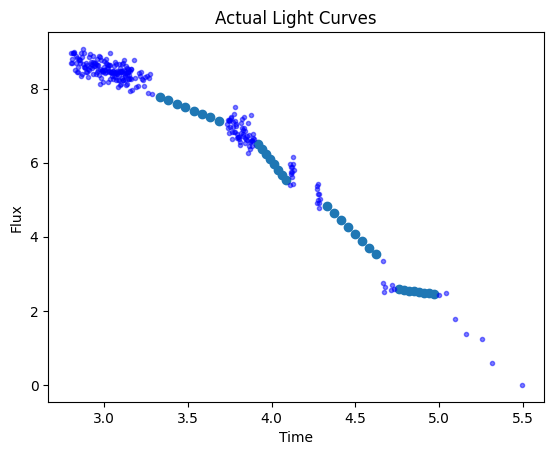

In [10]:
plt.plot(log_ts,symlog_flux, 'b.', alpha=0.5)
plt.scatter(upsampled_times,fluxes_imputed)

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title(f'Actual Light Curves')
plt.show()

In [11]:
# Join the arrays
all_times = np.concatenate([log_ts, upsampled_times])
all_fluxes = np.concatenate([symlog_flux, fluxes_imputed])

sorted_indices = np.argsort(all_times)
all_times = all_times[sorted_indices]
all_fluxes = all_fluxes[sorted_indices]


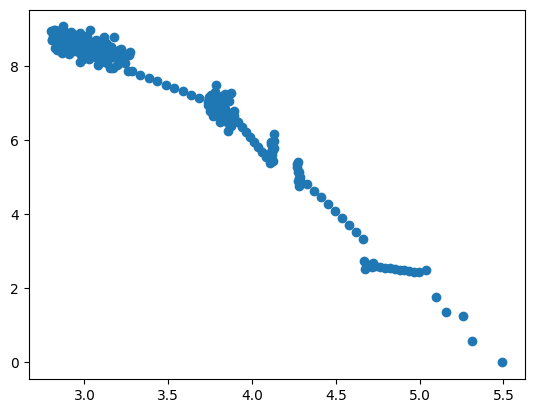

In [12]:
plt.scatter(all_times,all_fluxes)

In [13]:
#dividing data into training and validation

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(all_times.reshape(-1,1), all_fluxes.reshape(-1,1), test_size=0.3, random_state=42)


print(f"Training data size: {len(X_train)}")
print(f"Validation data size: {len(X_val)}")

Training data size: 207
Validation data size: 89


In [14]:
#Reshaping for LSTM input (samples, time steps, features)
#the timestep = 1

X_train_seq = X_train.reshape(X_train.shape[0], 1, 1)
X_val_seq = X_val.reshape(X_val.shape[0], 1, 1)

print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"y_val shape: {y_val.shape}")


X_train_seq shape: (207, 1, 1)
y_train shape: (207, 1)
X_val_seq shape: (89, 1, 1)
y_val shape: (89, 1)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import initializers

he_init = initializers.HeNormal()

model = Sequential()

model.add(Bidirectional(LSTM(100, kernel_initializer=he_init, return_sequences=True), input_shape=(1, 1)))
model.add(Bidirectional(LSTM(100, kernel_initializer=he_init, return_sequences=True)))
model.add(Bidirectional(LSTM(100, kernel_initializer=he_init, return_sequences=True)))
model.add(Bidirectional(LSTM(100, kernel_initializer=he_init)))

#dense layer with ReLU activation for non linear data
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='mean_squared_error')

#EarlyStopping with persistence for overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,  #wait for 10 epochs without improvement
                               restore_best_weights=True,  #restore weights at the best validation loss
                               verbose=1)

#ReduceLROnPlateau for learning rate adjustment
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,  #reduce lr by 10%
                              patience=5,  #wait for 5 epochs before reducing
                              min_lr=1e-6,  #minimum lr so it doesnt get v small
                              verbose=1)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
#Fit the model
history = model.fit(X_train_seq, y_train,
                    epochs=100,
                    batch_size=3,
                    validation_data=(X_val_seq, y_val),
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model on validation data
val_loss = model.evaluate(X_val_seq, y_val)
print(f'Validation Loss: {val_loss}')

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 54.2921 - val_loss: 59.8390 - learning_rate: 1.0000e-04
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 51.3569 - val_loss: 59.8390 - learning_rate: 1.0000e-04
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 55.7477 - val_loss: 59.8390 - learning_rate: 1.0000e-04
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 53.1116 - val_loss: 59.8390 - learning_rate: 1.0000e-04
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 56.2226 - val_loss: 59.8390 - learning_rate: 1.0000e-04
Epoch 6/100
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 56.6332
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 56.5819 - val_loss: 59.8390 - learning_rate: 1.0000e-04
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 52.7413 - val_loss: 59.8390 - learning_rate: 1.0000e-05
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - l

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 533ms/step


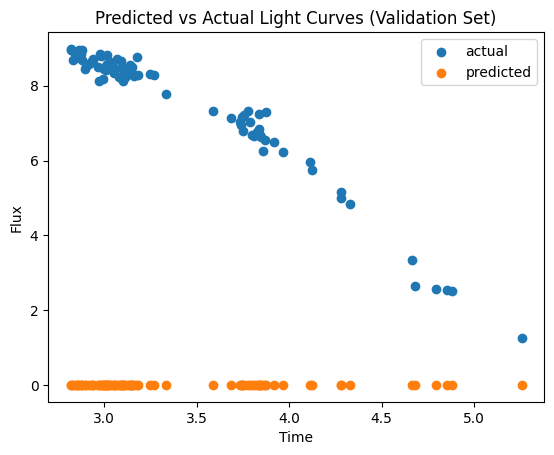

In [18]:
#Predict on validation data
y_pred = model.predict(X_val_seq)

plt.scatter(X_val,y_val,label='actual')
plt.scatter(X_val,y_pred,label='predicted')

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title(f'Predicted vs Actual Light Curves (Validation Set)')
plt.legend()
plt.show()

In [20]:
log_recon_seq = log_recon_t.reshape(log_recon_t.shape[0], 1, 1)

print(f"log_recon_seq shape: {log_recon_seq.shape}")

log_recon_seq shape: (193, 1, 1)


In [21]:
#Predict on new time
recon_pred = model.predict(log_recon_seq)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


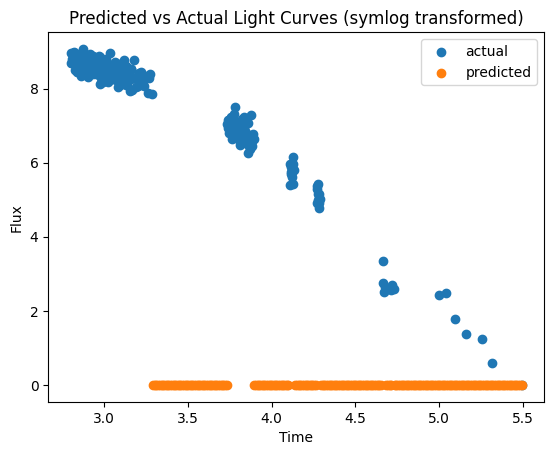

In [22]:
plt.scatter(log_ts,symlog_flux,label='actual')
plt.scatter(log_recon_t,recon_pred,label='predicted')

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title(f'Predicted vs Actual Light Curves (symlog transformed)')
plt.legend()
plt.show()

In [73]:


def inverse_symmetric_log(y, a):
    return a * (np.exp(y)) * np.sign(y)



In [74]:
#inverse symlog transformation

predicted_flux = inverse_symmetric_log(recon_pred, a)

recon_fluxes_up = np.log10(predicted_flux)

In [75]:
#CALCULATING TIME ERROR IN LINEAR SCALE
ts_error = (positive_ts_err - negative_ts_err)/2

#CALCULATING TIME ERROR IN LOG SCALE
log_ts_error = ts_error/(ts*np.log(10))

errparameters = st.norm.fit(log_ts_error) #GAUSSIAN FITTING ON TIME ERROR DISTRIBUTION
err_dist_time = st.norm(loc=errparameters[0], scale=errparameters[1])

recon_logtimeerr=err_dist_time.rvs(size=len(log_recon_t)) # len(log_ts_error)


In [76]:
#adding noise

fluxes_error = (positive_fluxes_err - negative_fluxes_err)/2
logfluxerrs = fluxes_error/(fluxes*np.log(10))


errparameters = st.norm.fit(logfluxerrs) #GAUSSIAN FITTING ON ERROR-BAR DISTRIBUTION
err_dist = st.norm(loc=errparameters[0], scale=errparameters[1])

recon_errorbar=err_dist.rvs(size=len(log_recon_t))

#Point specific noise
point_specific_noise = []
for j in range(len(recon_fluxes_up)):
    fitted_dist = norm(loc=recon_fluxes_up[j], scale=recon_errorbar[j])
    point_noise = fitted_dist.rvs() - recon_fluxes_up[j]
    point_specific_noise.append(point_noise)

point_specific_noise = np.array(point_specific_noise)

#Jiggle reconstructed points
jiggled_points = recon_fluxes_up + point_specific_noise


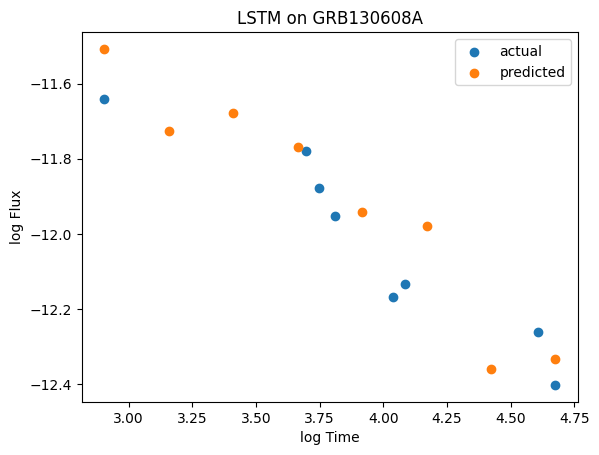

In [77]:
plt.scatter(log_ts,log_fluxes,label='actual')
plt.scatter(log_recon_t,jiggled_points,label='predicted')

plt.xlabel('log Time')
plt.ylabel('log Flux')
plt.title(f'LSTM on '+str(GRB_Name))
plt.legend()
plt.show()


In [78]:
num_samples = 1000  # Number of realizations
jiggled_realizations = []

for _ in range(num_samples):
    point_specific_noise = []
    for j in range(len(recon_fluxes_up)):
        fitted_dist = norm(loc=recon_fluxes_up[j], scale=recon_errorbar[j])
        point_noise = fitted_dist.rvs() - recon_fluxes_up[j]
        point_specific_noise.append(point_noise)
    jiggled_realizations.append(recon_fluxes_up + np.array(point_specific_noise))

jiggled_realizations = np.array(jiggled_realizations)

# Compute mean and 95% confidence intervals
mean_jiggled = np.mean(jiggled_realizations, axis=0)
ci_95_lower = np.percentile(jiggled_realizations, 2.5, axis=0)  # 2.5th percentile
ci_95_upper = np.percentile(jiggled_realizations, 97.5, axis=0)  # 97.5th percentile


In [79]:
ci_95_lower = ci_95_lower.flatten()
ci_95_upper = ci_95_upper.flatten()
log_recon_t = log_recon_t.flatten()
jiggled_points = jiggled_points.flatten()


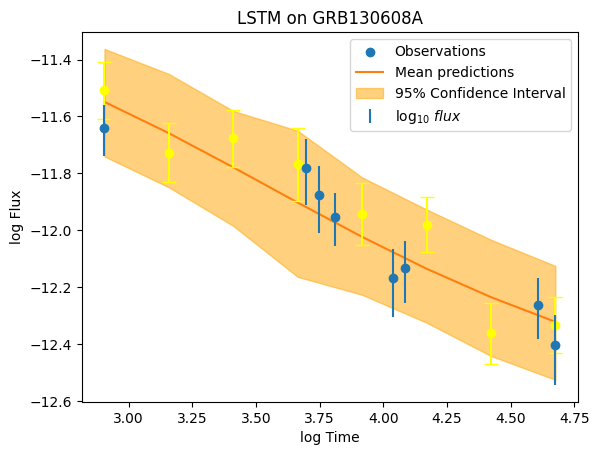

In [80]:

plt.errorbar(log_ts, log_fluxes, yerr=[log_fluxes-neg_log_fluxes,pos_log_fluxes-log_fluxes], label=r"$\log_{10}\,flux$", linestyle="",zorder=4)
plt.errorbar(log_recon_t, jiggled_points, linestyle='none', yerr=np.abs(recon_errorbar), marker='o', capsize=5, color='yellow',zorder=3)

plt.scatter(log_ts,log_fluxes,label='Observations',zorder=5)
plt.plot(log_recon_t,recon_fluxes_up,label='Mean predictions',zorder=2)
plt.fill_between(log_recon_t, ci_95_lower, ci_95_upper,color='orange', alpha=0.5, label='95% Confidence Interval',zorder=1)
plt.xlabel('log Time')
plt.ylabel('log Flux')
plt.title(f'LSTM on '+str(GRB_Name))
plt.legend()
plt.savefig('Images/'+str(GRB_Name)+".png", dpi=300)
plt.show()


In [81]:
df = trimmed_data.copy(deep=True)

for k in range(0, len(log_recon_t)):
    new_row = {
        "t": 10**log_recon_t[k],
        "pos_t_err": 10**recon_logtimeerr[k],
        "neg_t_err": 10**recon_logtimeerr[k],
        "flux": 10**jiggled_points[k],
        "pos_flux_err": 10**jiggled_points[k] * np.log(10) * recon_errorbar[k],
        "neg_flux_err": 10**jiggled_points[k] * np.log(10) * recon_errorbar[k]
    }

    new_row_df = pd.DataFrame([new_row])
    df = pd.concat([df, new_row_df], ignore_index=True)

Names.append(GRB_Name)


df.to_csv('csv files/'+str(GRB_Name)+'.csv')


In [82]:
from google.colab import files


In [ ]:
files.download('csv files')


In [222]:
files.download('Images')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
